QC operation test

In [1]:
# Importowanie biblioteki:

# Na początek wywołać w folderze projektu komendę
# maturin develop
# aby zbudować pakiet.

# Potem trzeba ustalić ścieżkę do lokalnego projektu polars-bio:
import pathlib
path_to_project = pathlib.Path().resolve().parent.parent
print(path_to_project)

# i wywołać tę sekcję jednokrotnie, aby dodać tę ścieżkę do path.
# Odinstalować też pakiet polars-bio, aby nie przykrył lokalnej wersji, np.
# pip3 uninstall polars-bio

# W przypadku potrzeby ponownego załadowania biblioteki, zrobić wcześniej Restart Kernel w Juputerze

import sys
sys.path.insert(0, str(path_to_project))
# print('\n'.join(sys.path))

import polars_bio
# print(polars_bio.__file__)


/home/user/Documents/studia2st/tbd/polars-bio


INFO:polars_bio:Creating BioSessionContext


Loaded polars_bio


In [2]:

fastq_file_path = f"{str(path_to_project)}/tests/data/io/fastq/example.fastq"

# czytanie z pliku
df = polars_bio.read_fastq(fastq_file_path).collect()
df

# dodane funkcjonalności: sequence_quality_score_histogram i sequence_quality_score
histogram_mean_quality = polars_bio.qc_operations.sequence_quality_score_histogram(df, output_type="polars.DataFrame")
mean_quality = polars_bio.qc_operations.sequence_quality_score(df, output_type="polars.DataFrame")

# zapis wyników
histogram_mean_quality.write_csv("mean_quality_histogram.csv")
mean_quality.write_csv("mean_quality.csv")

INFO:polars_bio.scan:Registering FASTQ table example with options: FastqReadOptions { thread_num: Some(1), object_storage_options: Some(ObjectStorageOptions { chunk_size: Some(8), concurrent_fetches: Some(1), allow_anonymous: true, enable_request_payer: false, max_retries: Some(5), timeout: Some(300), compression_type: Some(AUTO) }) }
INFO:polars_bio:Table: example registered for path: /home/user/Documents/studia2st/tbd/polars-bio/tests/data/io/fastq/example.fastq


0rows [00:00, ?rows/s]

INFO:polars_bio.operation:Running operation with 1 thread(s)...
INFO:polars_bio.operation:Running operation with 1 thread(s)...


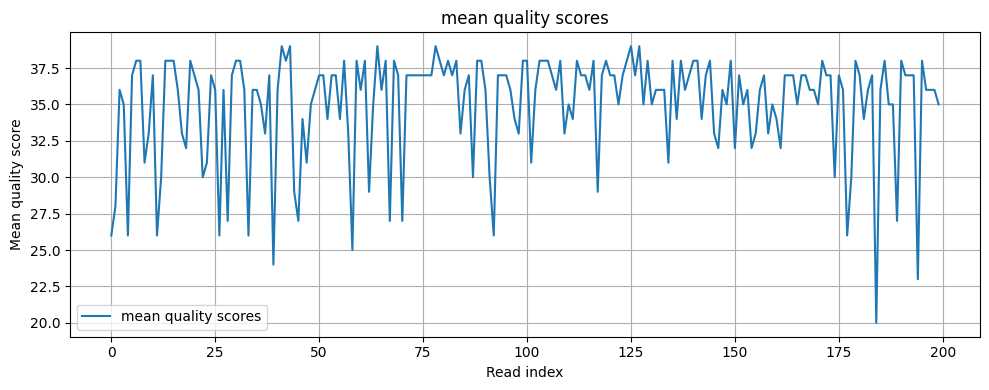

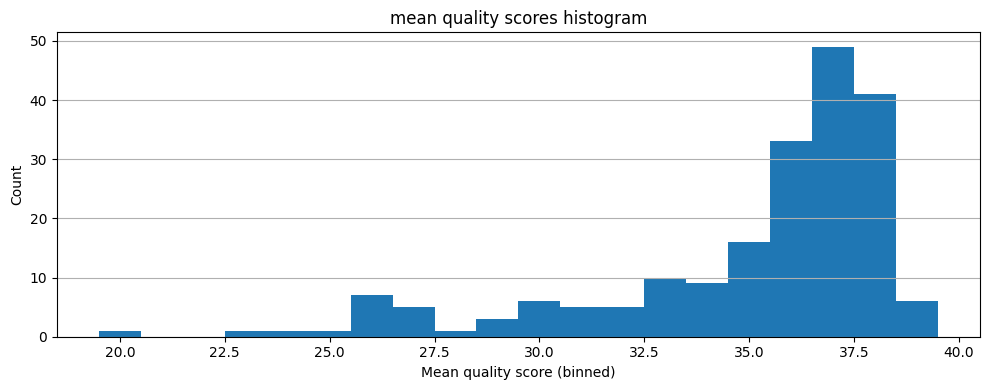

In [3]:
# Wizualizacja wyników
polars_bio.visualize_mean_quality(mean_quality)
polars_bio.visualize_mean_quality_histogram(histogram_mean_quality)


INFO:polars_bio.operation:Running operation with 8 thread(s)...
INFO:polars_bio.operation:Running operation with 8 thread(s)...
INFO:polars_bio.operation:Running operation with 8 thread(s)...
INFO:polars_bio.operation:Running operation with 8 thread(s)...
INFO:polars_bio.operation:Running operation with 8 thread(s)...
INFO:polars_bio.operation:Running operation with 8 thread(s)...
INFO:polars_bio.operation:Running operation with 8 thread(s)...
INFO:polars_bio.operation:Running operation with 8 thread(s)...
INFO:polars_bio.operation:Running operation with 8 thread(s)...
INFO:polars_bio.operation:Running operation with 8 thread(s)...
INFO:polars_bio.operation:Running operation with 8 thread(s)...
INFO:polars_bio.operation:Running operation with 8 thread(s)...
INFO:polars_bio.operation:Running operation with 8 thread(s)...
INFO:polars_bio.operation:Running operation with 8 thread(s)...
INFO:polars_bio.operation:Running operation with 8 thread(s)...
INFO:polars_bio.operation:Running operat

=== sequence_quality_score ===
        name       min       max      mean
0  threads=8  0.014169  0.020826  0.017104
1  threads=4  0.014976  0.017122  0.015608
2  threads=2  0.012866  0.014394  0.013588
3  threads=1  0.013526  0.015131  0.014044

=== sequence_quality_score_histogram ===
        name       min       max      mean
0  threads=8  0.029554  0.060053  0.038248
1  threads=4  0.026104  0.032307  0.028564
2  threads=2  0.025711  0.026150  0.025934
3  threads=1  0.023934  0.024315  0.024140


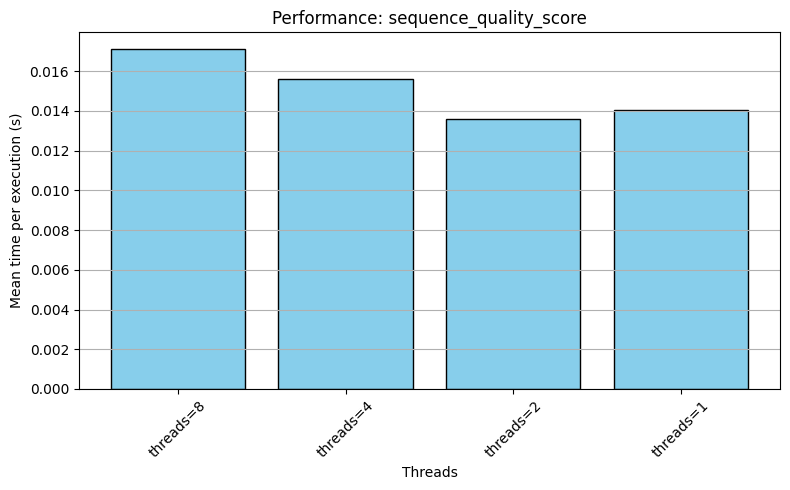

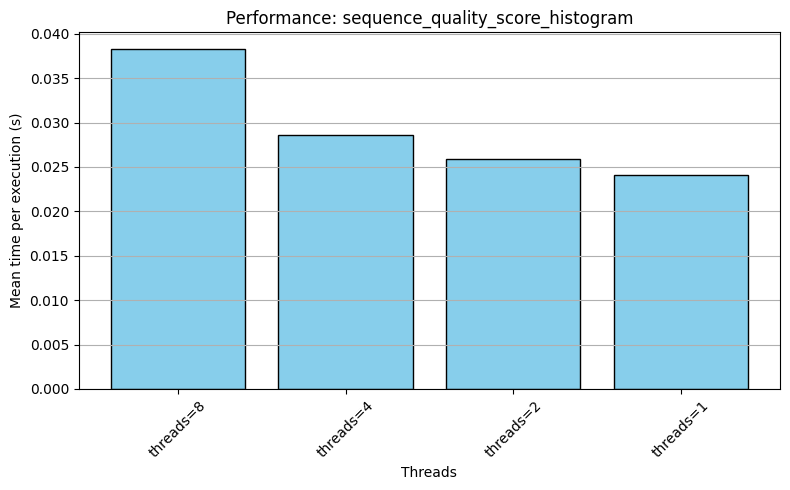

In [5]:
# Testy performance dla zmiennej liczby wątków
import timeit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Konfiguracja
test_threads = [8, 4, 2, 1]
num_repeats = 5
num_executions = 5

def benchmark_operation(name, func):
    times = timeit.repeat(func, repeat=num_repeats, number=num_executions)
    per_run_times = [t / num_executions for t in times]
    return {
        "name": name,
        "min": min(per_run_times),
        "max": max(per_run_times),
        "mean": np.mean(per_run_times),
    }

# Wyniki
results_quality = []
results_histogram = []

for p in test_threads:
    polars_bio.ctx.set_option("datafusion.execution.target_partitions", str(p))

    results_quality.append(
        benchmark_operation(
            f"threads={p}",
            lambda: polars_bio.qc_operations.sequence_quality_score(df, output_type="polars.DataFrame")
        )
    )

    results_histogram.append(
        benchmark_operation(
            f"threads={p}",
            lambda: polars_bio.qc_operations.sequence_quality_score_histogram(df, output_type="polars.DataFrame")
        )
    )

# Konwersja do DataFrame
df_quality = pd.DataFrame(results_quality)
df_histogram = pd.DataFrame(results_histogram)

# Wyświetlenie tabel
print("=== sequence_quality_score ===")
print(df_quality)
print("\n=== sequence_quality_score_histogram ===")
print(df_histogram)

# Wykres
def plot_results(df, title):
    plt.figure(figsize=(8, 5))
    plt.bar(df["name"], df["mean"], color="skyblue", edgecolor="black")
    plt.title(title)
    plt.ylabel("Mean time per execution (s)")
    plt.xlabel("Threads")
    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

plot_results(df_quality, "Performance: sequence_quality_score")
plot_results(df_histogram, "Performance: sequence_quality_score_histogram")

